<a href="https://colab.research.google.com/github/alfredamboka/DeepTech5Yr/blob/main/mainProjectCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import ee
#import geemap
#ee.Authenticate()
#ee.Initialize()




install and import geemap for convertion on js to py
Only applicable to Colab. In other cases or environment install normally and comment the cell below.

In [ ]:
try:
    import geemap
except ModuleNotFoundError:
    if 'google.colab' in str(get_ipython()):
        print('geemap not found, installing via pip in Google Colab...')
        !pip install geemap --quiet
        import geemap
    else:
        print('geemap not found, please install via conda in your environment')

##J.S - P.y
Code to automatically convert GEE code from JavaScript to Python
- The cell below is used.
- Any js code provided will be converted to python.
- Write python code and js code in different cells

In [ ]:
javascript_code = """
// Series of strings here!


"""

In [ ]:
lines = geemap.js_snippet_to_py(
    javascript_code, add_new_cell=False,
    import_ee=True, import_geemap=True, show_map=True)
for line in lines:
    print(line.rstrip())

import ee
import geemap
Map = geemap.Map()
import geemap

Map = geemap.Map()

# Series of strings here!

Map


## Datasets
- Load all the required dataset in this section.


In [ ]:
#

## Crop Phenology Extraction
- Used to determine the growing seasons
- Also used to aid in futher data filtering.




Extraction ofcrop phenlogical periods usng NDVI and EVI Curves.
Image fusion of sentinel and Modis used.


Only EVI curve using fused sentinel and MODIS Data.superimposed graphs  at two years interval for proper visualization


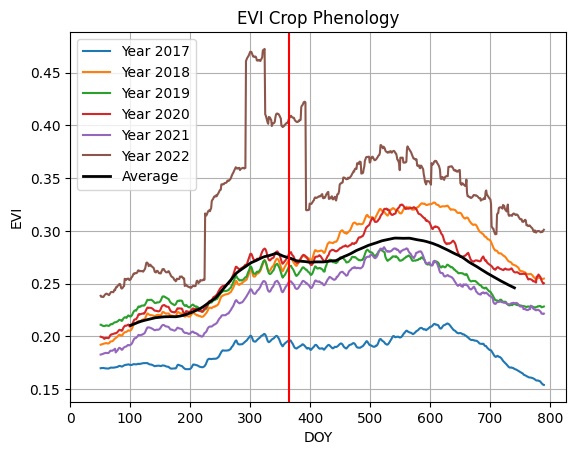

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define study area
#study_area = ee.FeatureCollection('projects/project5yr/assets/Croplands').geometry()
study_area = ee.FeatureCollection('projects/project5yr/assets/BuraStudyArea').geometry()

# Create a list of years from 2018 to 2022
years = range(2017, 2023)

# Create empty lists to store the mean values for each year
evi_mean_values = []

# Create an empty DataFrame to store all EVI values
all_evi_df = pd.DataFrame()

# Iterate over each year
for year in years:
    # Define start and end dates for the current year
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'

    # Load Sentinel-2, Landsat, and MODIS images for the current year
    sentinel = ee.ImageCollection('COPERNICUS/S2_SR') \
        .filterBounds(study_area) \
        .filterDate(start_date, end_date) \
        .map(lambda image: image.clip(study_area)) \
        .map(lambda image: image.updateMask(image.select(['QA60']).bitwiseAnd(2 ** 10).eq(0))) \
        .map(lambda image: image.divide(10000).float()) \
        .map(lambda image: image.expression('2.5 * (b("B8") - b("B4")) / (1 + b("B8") + 6 * b("B4") - 7.5 * b("B2"))', {
            'B2': image.select('B2'),
            'B4': image.select('B4'),
            'B8': image.select('B8')
        }).rename('EVI').copyProperties(image, image.propertyNames()))

    landsat = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
        .filterBounds(study_area) \
        .filterDate(start_date, end_date) \
        .map(lambda image: image.clip(study_area)) \
        .map(lambda image: image.divide(10000).float()) \
        .map(lambda image: image.expression('2.5 * (b("B5") - b("B4")) / (1 + b("B5") + 6 * b("B4") - 7.5 * b("B2"))', {
            'B4': image.select('B4'),
            'B5': image.select('B5'),
            'B2': image.select('B2')
        }).rename('EVI').copyProperties(image, image.propertyNames()))

    modis = ee.ImageCollection('MODIS/006/MOD13A1') \
        .filterBounds(study_area) \
        .filterDate(start_date, end_date) \
        .map(lambda image: image.clip(study_area)) \
        .map(lambda image: image.divide(10000).float()) \
        .select('EVI')

    # Merge the image collections
    image_collection = sentinel.merge(landsat).merge(modis)

    # Create a fusion function
    def fusionFunction(images):
        return ee.Image(images.mean())

    # Apply the fusion function to the image collection
    fused_image = image_collection.reduce(ee.Reducer.intervalMean(50, 100)).rename('EVI')

    # Reduce region and extract EVI values as a nested list
    evi_values = fused_image.reduceRegion(reducer=ee.Reducer.toList(), geometry=study_area, scale=500).getInfo()

    # Convert the nested list to a Pandas DataFrame
    evi_df = pd.DataFrame(evi_values.get('EVI'), columns=['EVI'])

    # Add day of the year (DOY) column
    evi_df['doy'] = range(1, len(evi_df) + 1)

    # Smooth curve using moving average
    evi_df['EVI_smooth'] = evi_df['EVI'].rolling(window=100, center=True).mean()

    # Fit curve using polynomial regression
    evi_fit = np.polyfit(evi_df['doy'], evi_df['EVI_smooth'], deg=6)

    # Calculate the mean EVI value for the current year
    evi_mean = evi_df['EVI'].mean()

    # Store the mean value
    evi_mean_values.append(evi_mean)

    # Merge the current year's EVI DataFrame with the overall DataFrame
    all_evi_df = pd.concat([all_evi_df, evi_df], ignore_index=True)

    # Plot EVI curve with fitted curve for the current year
    plt.plot(evi_df['doy'], evi_df['EVI_smooth'], label=f'Year {year}')

# Calculate the average EVI values across all years
avg_evi_df = all_evi_df.groupby('doy')['EVI_smooth'].mean().reset_index()

# Smooth the average EVI curve using moving average
avg_evi_df['EVI_avg_smooth'] = avg_evi_df['EVI_smooth'].rolling(window=100, center=True).mean()

# Fit curve using polynomial regression
avg_evi_fit = np.polyfit(avg_evi_df['doy'], avg_evi_df['EVI_avg_smooth'], deg=6)

# Plot the average EVI curve with the fitted curve
plt.plot(avg_evi_df['doy'], avg_evi_df['EVI_avg_smooth'], color='black', linewidth=2, label='Average')
plt.xlabel('DOY')
plt.ylabel('EVI')
plt.title('EVI Crop Phenology')
plt.legend()
plt.grid(True)

plt.xticks(np.arange(0, len(avg_evi_df['doy']), 730))
plt.xticks(np.arange(0, len(avg_evi_df['doy']), 100))
plt.axvline(x=365, color='red', linestyle='-')
plt.show()



Superimposed graphs. ONLY NDVI. Showing  Crop phenology between consecutive years and an average curve.

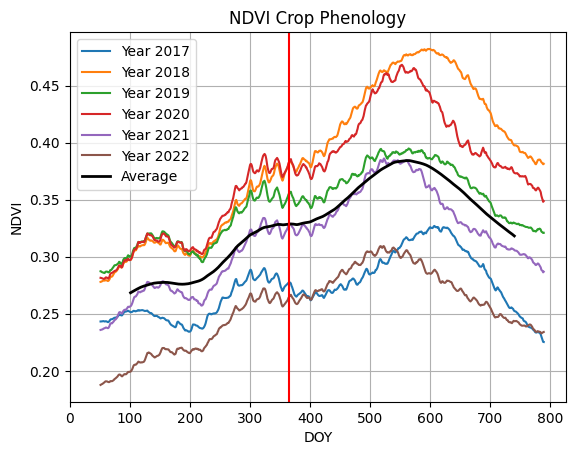

Map(center=[-1.17071, 39.876021], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(…

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define study area
#study_area = ee.FeatureCollection('projects/project5yr/assets/Croplands').geometry()
study_area = ee.FeatureCollection('projects/project5yr/assets/BuraStudyArea').geometry()

# Create a list of years from 2018 to 2022
years = range(2017, 2023)

# Create empty lists to store the mean values for each year
ndvi_mean_values = []

# Create an empty DataFrame to store all NDVI values
all_ndvi_df = pd.DataFrame()

# Iterate over each year
for year in years:
    # Define start and end dates for the current year
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'

    # Load Sentinel-2, Landsat, and MODIS images for the current year
    sentinel = ee.ImageCollection('COPERNICUS/S2_SR') \
        .filterBounds(study_area) \
        .filterDate(start_date, end_date) \
        .map(lambda image: image.clip(study_area)) \
        .map(lambda image: image.updateMask(image.select(['QA60']).bitwiseAnd(2 ** 10).eq(0))) \
        .map(lambda image: image.divide(10000).float()) \
        .map(lambda image: image.expression('(b("B8") - b("B4")) / (b("B8") + b("B4"))', {
            'B4': image.select('B4'),
            'B8': image.select('B8')
        }).rename('NDVI').copyProperties(image, image.propertyNames()))

    landsat = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
        .filterBounds(study_area) \
        .filterDate(start_date, end_date) \
        .map(lambda image: image.clip(study_area)) \
        .map(lambda image: image.divide(10000).float()) \
        .map(lambda image: image.expression('(b("B5") - b("B4")) / (b("B5") + b("B4"))', {
            'B4': image.select('B4'),
            'B5': image.select('B5')
        }).rename('NDVI').copyProperties(image, image.propertyNames()))

    modis = ee.ImageCollection('MODIS/006/MOD13A1') \
        .filterBounds(study_area) \
        .filterDate(start_date, end_date) \
        .map(lambda image: image.clip(study_area)) \
        .map(lambda image: image.divide(10000).float()) \
        .select('NDVI')

    # Merge the image collections
    image_collection = sentinel.merge(landsat).merge(modis)

    # Create a fusion function
    def fusionFunction(images):
        return ee.Image(images.mean())

    # Apply the fusion function to the image collection
    fused_image = image_collection.reduce(ee.Reducer.intervalMean(50, 100)).rename('NDVI')

    # Reduce region and extract NDVI values as a nested list
    ndvi_values = fused_image.reduceRegion(reducer=ee.Reducer.toList(), geometry=study_area, scale=500).getInfo()

    # Convert the nested list to a Pandas DataFrame
    ndvi_df = pd.DataFrame(ndvi_values.get('NDVI'), columns=['NDVI'])

    # Add day of the year (DOY) column
    ndvi_df['doy'] = range(1, len(ndvi_df) + 1)

    # Smooth curve using moving average
    ndvi_df['NDVI_smooth'] = ndvi_df['NDVI'].rolling(window=100, center=True).mean()

    # Fit curve using polynomial regression
    ndvi_fit = np.polyfit(ndvi_df['doy'], ndvi_df['NDVI_smooth'], deg=6)

    # Calculate the mean NDVI value for the current year
    ndvi_mean = ndvi_df['NDVI'].mean()

    # Store the mean value
    ndvi_mean_values.append(ndvi_mean)

    # Merge the current year's NDVI DataFrame with the overall DataFrame
    all_ndvi_df = pd.concat([all_ndvi_df, ndvi_df], ignore_index=True)

    # Plot NDVI curve with fitted curve for the current year
    plt.plot(ndvi_df['doy'], ndvi_df['NDVI_smooth'], label=f'Year {year}')

# Calculate the average NDVI values across all years
avg_ndvi_df = all_ndvi_df.groupby('doy')['NDVI_smooth'].mean().reset_index()

# Smooth the average NDVI curve using moving average
avg_ndvi_df['NDVI_avg_smooth'] = avg_ndvi_df['NDVI_smooth'].rolling(window=100, center=True).mean()

# Fit curve using polynomial regression
avg_ndvi_fit = np.polyfit(avg_ndvi_df['doy'], avg_ndvi_df['NDVI_avg_smooth'], deg=6)

# Plot the average NDVI curve with the fitted curve
plt.plot(avg_ndvi_df['doy'], avg_ndvi_df['NDVI_avg_smooth'], color='black', linewidth=2, label='Average')
plt.xlabel('DOY')
plt.ylabel('NDVI')
plt.title('NDVI Crop Phenology')
plt.legend()
plt.grid(True)

plt.xticks(np.arange(0, len(avg_ndvi_df['doy']), 730))
plt.xticks(np.arange(0, len(avg_ndvi_df['doy']), 100))
plt.axvline(x=365, color='red', linestyle='-')
plt.show()

Map = geemap.Map()
Map.addLayer(fused_image, {'min': -1, 'max': 1, 'palette': ['red', 'yellow', 'green']}, f'NDVI {year}')
# Display the map
Map.setCenter( 39.876021,-1.17071,12)
Map.addLayerControl()
Map

---
Utilizing EVI to Identify crop phenology periods. Two years interval for proper mapping.
Superimposed curves.


## Batch Export
- Create a function that will enhance batch export of any output required.

In [ ]:
#check end-to-end course solution to export bulk images.

### Testing section